In [1]:
import pandas as pd

In [2]:
emb_df = pd.read_csv('../data/embedding/Glove_embedding_output.csv',index_col=0)

In [3]:
emb_df.shape

(211577, 100)

In [4]:
emb_df.mean(axis=1).plot()

In [5]:
def read_article_df(file):
    articles_dt = file.read().split('\n')[:-1]
    pubId, canonicalUrl,firstScrape,title,text,lang_reliability = [],[],[],[],[],[]
    for article in articles_dt:    
        row = article.split('\t')
        pubId.append(row[0])
        canonicalUrl.append(row[4])
        firstScrape.append(row[5])
        lang_reliability.append(row[7])
        title.append(row[8])
        text.append(row[9])

    articles_df = pd.DataFrame()
    articles_df['pubId'] = pubId
    articles_df['canonicalUrl'] = canonicalUrl
    articles_df['firstScrape'] = firstScrape
    articles_df['title'] = title
    articles_df['text'] = text
    articles_df['lang_reliability'] = lang_reliability
    return articles_df

In [6]:
article_df = read_article_df(open('../data/raw/2018_07_19_04_59_08/articles.txt', encoding='utf-8'))

In [7]:
article_df.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability
0,290,zerohedge.com/news/2018-07-19/i-told-you-so-tr...,7/19/2018 10:41:26 AM -04:00,"""I Told You So"": Trump Hits Out At EU After $5...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1
1,290,zerohedge.com/news/2018-07-19/trump-invites-pu...,7/19/2018 5:03:01 PM -04:00,Trump Invites Putin To Ahead Of Midterms | Ze...,"by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1
2,290,zerohedge.com/news/2018-07-19/gallup-shows-how...,7/19/2018 8:26:52 AM -04:00,Gallup Shows How Much Americans Really Care Ab...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1
3,290,zerohedge.com/news/2018-07-19/california-supre...,7/19/2018 8:26:52 AM -04:00,California Supreme Court Blocks Proposal To Sp...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1
4,290,zerohedge.com/news/2018-07-19/why-are-thousand...,7/19/2018 4:28:52 PM -04:00,"Why Are ""Thousands"" of Teslas Sitting In a Fie...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1


In [8]:
article_df = article_df[article_df.lang_reliability == '1']

In [9]:
article_df.shape

(211577, 6)

In [ ]:
import networkx as nx
import community
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np
from collections import defaultdict
from sklearn.neighbors import BallTree
import gc
%matplotlib inline

In [11]:
sample_emb_df = emb_df.sample(50000)

In [12]:
sample_emb_df.shape

(50000, 100)

In [13]:
tree = BallTree(sample_emb_df)

In [ ]:
neighbors = tree.query_radius(sample_emb_df, 0.2)

In [30]:
neighbors[0]

array([33601,  6127,     0, 27974, 46162], dtype=int64)

In [27]:
neighbors_count = [len(n) for n in neighbors]

In [28]:
np.mean(neighbors_count)

266.06348

(array([45978.,   461.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  3561.]),
 array([1.0000e+00, 3.6330e+02, 7.2560e+02, 1.0879e+03, 1.4502e+03,
        1.8125e+03, 2.1748e+03, 2.5371e+03, 2.8994e+03, 3.2617e+03,
        3.6240e+03]),
 <a list of 10 Patch objects>)

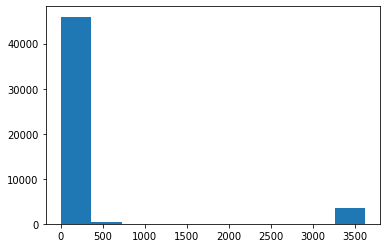

In [29]:
plt.hist(neighbors_count)

In [31]:
G = nx.Graph()

In [32]:
G.add_nodes_from(list(range(len(neighbors))))

In [33]:
for node in range(len(neighbors)):
    neighbor = neighbors[node]
    for n in neighbor:
        G.add_edge(node, n)

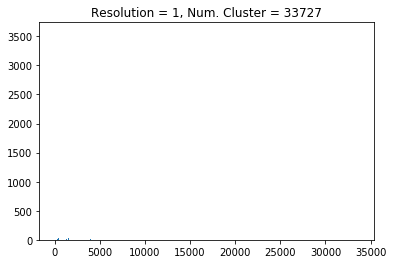

In [34]:
partitions = []
resolutions = [1] #, .99, .999, .9995, .9999]
for resolution in resolutions:
    partition = community.best_partition(G, resolution=resolution)
    partitions.append(partition)
    num_cluster = max([v for k,v in partition.items()]) + 1
    clusters = defaultdict(list)
    for k, v in partition.items():
        clusters[v].append(k)

    cluster_sizes = []
    for i, cluster in clusters.items():
        cluster_sizes.append(len(cluster))
    plt.bar(list(range(len(cluster_sizes))), cluster_sizes)
    plt.title(f'Resolution = {resolution}, Num. Cluster = {num_cluster}')
    plt.show()

In [39]:
np.max(cluster_sizes)

3562

In [40]:
np.median(cluster_sizes)

1.0

In [41]:
p = partitions[0]

In [46]:
pruned_cluster = {}
for key, value in clusters.items():
    if len(value) > 1:
        pruned_cluster[key] = value

In [48]:
len(pruned_cluster.keys())

3429

In [60]:
def plot_cluster_sizes(cluster):
    cluster_sizes = []
    for i, c in cluster.items():
        cluster_sizes.append(len(c))
    plt.title(f'Num cluster = {len(cluster.keys())}')
    plt.hist(cluster_sizes)
    plt.show()

8


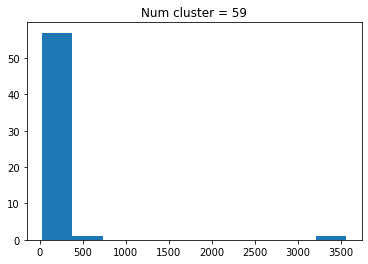

In [66]:
pruned_cluster2 = {}
for key, value in clusters.items():
    if len(value) > 25:
        pruned_cluster2[key] = value
print(i)
plot_cluster_sizes(pruned_cluster2)

In [67]:
pc = pruned_cluster2

In [78]:
article_cluster =list(map(lambda d: article_df.iloc[d[1]], pc.items()))

In [79]:
len(article_cluster)

59

In [85]:
len(article_cluster[0].title.tolist())

3562

In [86]:
article_cluster[1].title.tolist()

['US "Diplomacy"',
 'Video: 3 Secrets To Using MoviePass ',
 'Wallpaper fermions and the nonsymmorphic Dirac insulator | Science',
 'Didi, SoftBank set up taxi-hailing joint venture in Japan - WECT TV6-WECT.com:News, weather & sports Wilmington, NC',
 'Jailed Audi chief seeks release pending German fraud ',
 'More Tennesseans Are Sporting Confederate Flag License Plates Than Ever Before - American Renaissance',
 'Whole Foods store sets opening date for 2nd Charleston-area stor - Live5News.com | Charleston, SC | News, Weather, Sports',
 'US crude oil production hit record level in ',
 '',
 '',
 'Skylark',
 'Pass Notes: Gianni Versace, archive, 20 July 199',
 '',
 'Chinese culture-centric Lotus Festival blooms in  - Worldnews.com',
 'Lose weight by snack swapping',
 'Laetitia Casta: Biography',
 'Good school is one that matches your child’s qualities— Adeniyi - Vanguard News',
 'Sources: Kawhi Leonard and Danny Green traded to Toronto for DeMar DeRozan and package',
 'US, allies set to e

In [91]:
article_df[article_df.title == ''].canonicalUrl.tolist()

['dailyamerican.com/news/nation/today-in-history/article_c358c80b-15e9-56e3-a227-80c43251d8a5.html',
 'gopsusports.com/genrel/071918aab.html',
 'timesbulletin.com/content/default/electronic-edition/flipbook/july-18-2018/-3/1202/405',
 'oascentral.sciencemag.org/realmedia/ads/click_lx.ads/www.sciencemag.org/site/help/librarians/index.xhtml/1402611411/right1/default/empty.gif/43734251653174527268384144427755',
 'sciencemag.org/features/2008/06/topright2x30x51x60',
 'oascentral.sciencemag.org/realmedia/ads/click_lx.ads/www.sciencemag.org/site/collections/online/special/2121129259/right1/default/empty.gif/6562695a465674527243554141794e71',
 'oascentral.sciencemag.org/realmedia/ads/click_lx.ads/classic.sciencemag.org/feedback/56916951/right2/default/empty.gif/6238555246317452746849414176494a',
 'oascentral.sciencemag.org/realmedia/ads/click_lx.ads/www.sciencemag.org/site/my_account/access_rights.xhtml/l23/1504370494/right2/aaas/house-all-sites-pub-apritchard-ros-jobs-app-010118-063018/48630

In [93]:
from sklearn.neighbors import NearestNeighbors

In [95]:
nn = NearestNeighbors().fit(emb_df)

In [96]:
sample = emb_df.sample(); sample

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
28240,0.052505,0.081911,0.146123,-0.077288,-0.070794,0.023398,-0.273355,0.045487,0.0724,-0.122332,...,-0.231833,0.127755,0.072807,-0.309596,-0.24348,-0.015605,0.123577,-0.11049,0.338282,0.015329


In [97]:
article_df.iloc[sample.index]

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability
28432,20,reddit.com/user/throwaway12534968,7/19/2018 7:52:21 AM -04:00,Throwaway12534968 (u/Throwaway12534968) - Reddit,Press J to jump to the feed. Press question ma...,1


In [98]:
dist, indices = nn.kneighbors(sample)

In [99]:
indices

array([[28240, 91093, 67673, 67745, 49590]], dtype=int64)

In [101]:
article_df.iloc[indices[0]]

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability
28432,20,reddit.com/user/throwaway12534968,7/19/2018 7:52:21 AM -04:00,Throwaway12534968 (u/Throwaway12534968) - Reddit,Press J to jump to the feed. Press question ma...,1
91945,6,yahoo.com/news/credit-card-issuers-paying-more...,7/19/2018 6:23:42 AM -04:00,Credit Card Issuers Paying More Than Ever in R...,Credit Card Issuers Paying More Than Ever in R...,1
68284,223,autoblog.com/used-detail--1646080708007474062-...,7/20/2018 4:53:24 AM -04:00,"Paoli, PA",Use our calculator Apply for financing ### Sel...,1
68356,223,autoblog.com/used-detail-279455743251530903-do...,7/20/2018 5:08:22 AM -04:00,"2018 Dodge Charger SXT for sale in Paoli, PA",Use our calculator Apply for financing ### Sel...,1
50006,813,forums.androidcentral.com/samsung-galaxy-note-...,7/19/2018 11:01:00 PM -04:00,Note 9 Promotions,Note 9 Promotions ### Originally Posted by jhi...,1
